In [1]:
import re #regex
import os #operating system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
directory = 'csv/perf_only_algorithm'
files = []
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if (re.match("^fwa_dev_v_.*", filename)) and (not re.match("^fwa_dev_v_.*_pitch.*", filename)):
      files.append(file_path)
      print(file_path)

csv/perf_only_algorithm/fwa_dev_v_1_1__n_080__b_08__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_080__b_16__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_1200__b_08__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_1200__b_16__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_1200__b_24__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_160__b_08__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_160__b_16__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_160__b_32__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_240__b_08__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_240__b_16__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_240__b_24__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_320__b_08__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_320__b_16__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_320__b_32__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_480__b_08__t_10.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_480__b_16__t_10.csv
csv/perf_only_algorit

In [3]:
# for filename in files :
#     f = open(filename, "r")
#     print(f.read())
#     f.close()

In [4]:
def obtain_parameter(in_string, par_name) :
    par_regex = "-" + par_name + "=[^ \n]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub(".*=", "", par_string)
    return par_value

def obtain_version(in_string) :
    par_regex = "v_[^. ]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub("v_", "", par_string)
    return par_value

In [5]:
def obtain_all_parameters(in_file) :
    with open(in_file) as fp :
      for i, line in enumerate(fp) :
        if i == 0 :
            n = int(obtain_parameter(line, "n"))
            b = int(obtain_parameter(line, "b"))
            t = int(obtain_parameter(line, "t"))
            s = int(obtain_parameter(line, "s"))
            version = obtain_version(line)

        elif i == 3 :
            headers = line.replace('"', '').replace("\n", "").split(",")

        elif i == 4 :
            temp = line.replace("\n", "").replace("%", "").split(",")
            unit_measures = []
            for unit in temp :
              if unit != "" :
                unit = "(" + unit + ")"
              unit_measures.append(unit)

        elif i > 4 :
            break

    headers = list(map(lambda x, y: x + y, headers, unit_measures))

    return n, b, t, s, version, headers

In [6]:
df_nvprof_big = pd.DataFrame()     # collects all data
df_nvprof = pd.DataFrame()   # sums up everything
for filename in files : 
    #print(filename)
    n, b, t, s, version, headers = obtain_all_parameters(filename)
    time = headers[2]
    temp_df_big = pd.read_csv(filename, skiprows=5, names=headers)
    temp_df_big['version'] = version
    temp_df_big['n'] = n
    temp_df_big['b'] = b
    temp_df_big['tests'] = t
    temp_df_big['seed'] = s
    if df_nvprof.empty :
      df_nvprof_big = pd.DataFrame(columns = headers)
      df_nvprof = pd.DataFrame(columns = ['version', 'n', 'b', 'tests', 'seed', time])
    df_nvprof_big = pd.concat([df_nvprof_big, temp_df_big])
    tot_time = temp_df_big[time].sum()
    #print(f"version = {version}, n = {n}, b = {b}, t = {t}, tot_time = {tot_time:.2f}")
    df_nvprof.loc[-1] = [version, n, b, t, s, tot_time]  # adding a row
    df_nvprof.index = df_nvprof.index + 1  # shifting index
    df_nvprof = df_nvprof.sort_index()  # sorting by index
df_nvprof = df_nvprof.sort_values(by = ['n', 'b', 'seed', 'tests', time])


In [7]:
#GPU, API in detail
print(df_nvprof_big)

              Type    Time(%)   Time(ms)  Calls   Avg(ms)   Min(ms)   Max(ms)  \
0   GPU activities  99.858949   50.11263  10000  0.005011  0.003872  0.013088   
1   GPU activities   0.083661   0.041984     10  0.004198   0.00416  0.004256   
2   GPU activities   0.057389     0.0288     10   0.00288  0.002816   0.00304   
3        API calls  64.586882  47.196088  10000  0.004719  0.003197  1.413384   
4        API calls  18.893286  13.806042    300   0.04602  0.006081  0.154578   
..             ...        ...        ...    ...       ...       ...       ...   
14       API calls   0.278688   2.426128     10  0.242612  0.231029  0.265315   
15       API calls   0.027777   0.241817     10  0.024181  0.018609    0.0287   
16       API calls   0.015523   0.135136     10  0.013513  0.011047  0.024572   
17       API calls    0.01045   0.090972     10  0.009097  0.007943  0.013145   
18       API calls   0.000342   0.002979      1  0.002979  0.002979  0.002979   

                           

In [8]:
#total sum per each (version,n,b,seed)
df_nvprof[time] = df_nvprof[time] / df_nvprof['tests']
print(df_nvprof)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df_nvprof)

    version     n   b  tests    seed     Time(ms)
167     1_3    80   8     10  735774     1.920881
119     2_0    80   8     10  735774     1.926844
191     1_2    80   8     10  735774     2.015982
95      2_2    80   8     10  735774     2.031336
143     1_4    80   8     10  735774     2.124043
..      ...   ...  ..    ...     ...          ...
163     1_3  1200  24     10  735774   114.223185
139     1_4  1200  24     10  735774   114.743786
187     1_2  1200  24     10  735774   194.498809
19      3_2  1200  24     10  735774   220.894555
211     1_1  1200  24     10  735774  6622.922876

[216 rows x 6 columns]


In [9]:
df_chrono = pd.read_csv('csv/all_performances.csv')
df_chrono['Mean Squared Error(ms)'] = df_chrono['Mean Squared Error(ms)']
df_chrono['Mean Squared Error(%)'] = df_chrono['Mean Squared Error(%)'].str.strip('%').astype(float) / 100
print(df_chrono)

    version     seed     n   b   t   Time(ms)  Mean Squared Error(ms)  \
0       1_3  5929024    80   8  10   1.650665                4.207820   
1       1_3  5929024    80  16  10   1.245507                2.684326   
2       1_3  5929024   160   8  10   2.106198                2.607151   
3       1_3  5929024   160  16  10   2.059278                2.561897   
4       1_3  5929024   160  32  10   2.464175                2.549266   
..      ...      ...   ...  ..  ..        ...                     ...   
211     2_2  5929024   720  16  10  16.697358                4.533891   
212     2_2  5929024   720  24  10  16.197677                2.600660   
213     2_2  5929024  1200   8  10  49.885303                3.076880   
214     2_2  5929024  1200  16  10  48.429155                5.716060   
215     2_2  5929024  1200  24  10  46.406707                5.357946   

     Mean Squared Error(%)  
0                 2.549166  
1                 2.155208  
2                 1.237847  
3      

In [10]:
na_columns = df_nvprof_big.columns[df_nvprof_big.isna().any()].tolist()
if na_columns == [] :
    print("No NaN values found")
else :
    print("Columns with NaN:")
    print(na_columns)

No NaN values found


In [11]:
versions_to_remove = ['1_1', '3_2']
versions = np.unique(df_nvprof['version'])
versions = versions.tolist()
versions = [ elem for elem in versions if elem not in versions_to_remove]
print(versions)

['1_2', '1_3', '1_4', '2_0', '2_2', '3_0', '3_1']


In [12]:
def plot_perf_version(df, y_axis, analyzer, versions=versions) :
    rows = 2
    cols = 2
    fig, axis = plt.subplots(rows, cols, figsize=(15, 10))
    idx = 0
    df_filtered = df[df['version'].isin(versions)]
    fig.suptitle("Performance of versions with " + analyzer,  fontsize=16)
    max_y = max(df_filtered[y_axis])
    for b in range(8, 33, 8):
        i = (int) (idx / cols)
        j = (int) (idx % cols)
        df_plot = df_filtered[(df_filtered['b'] == b)]
        for label, grp in df_plot.groupby(['version']):
            sub_title = "B = " + str(b)
            grp.plot(ax=axis[i][j], kind='line', x='n', y=y_axis, xlabel='Matrix Size', ylabel=y_axis, label=label, title=sub_title, ylim=(0,max_y), marker='o')
        idx += 1

    out_filename = 'png/versions_performance_' + analyzer + '.png'
    plt.savefig(out_filename, facecolor='white', transparent=False)

In [13]:
def plot_perf_B(df, y_axis, analyzer, versions=versions) :
    rows = 2
    cols = 4
    fig, axis = plt.subplots(rows, cols, figsize=(25, 10))
    idx = 0
    df_filtered = df[df['version'].isin(versions)]
    fig.suptitle("Performance of blocking factors with " + analyzer,  fontsize=16)
    max_y = max(df_filtered[y_axis])
    for v in versions:
        i = (int) (idx / cols)
        j = (int) (idx % cols)
        df_plot = df_filtered[(df_filtered['version'] == v)]
        for label, grp in df_plot.groupby(['b']):
            sub_title = "version = " + v
            grp.plot(ax=axis[i][j], kind='line', x='n', y=y_axis, xlabel='Matrix Size', ylabel=y_axis, label=label, title=sub_title, ylim=(0,max_y), marker='o')
        idx += 1

    out_filename = 'png/blocking_factors_performance_' + analyzer + '.png'
    plt.savefig(out_filename, facecolor='white', transparent=False)

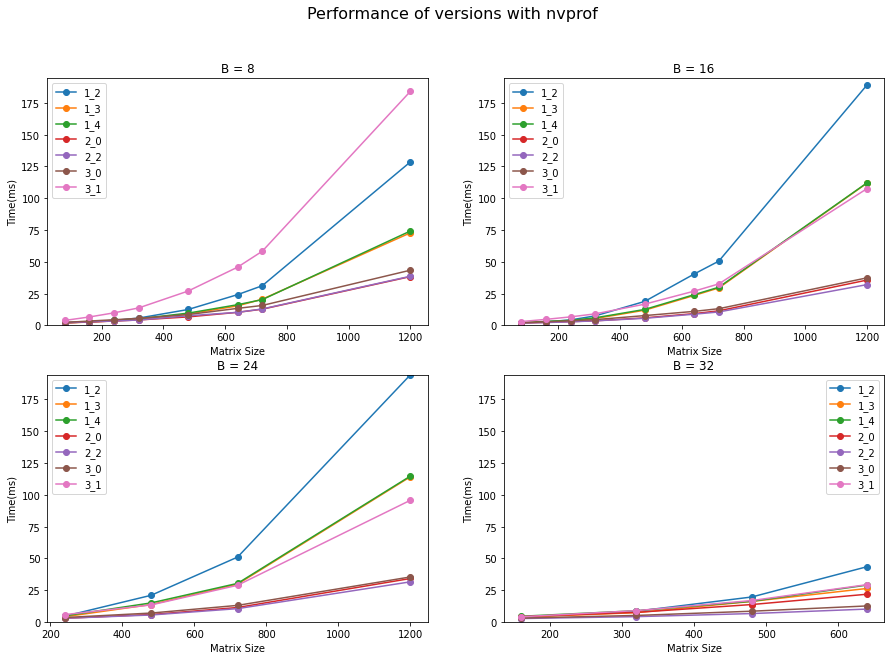

In [14]:
plot_perf_version(df_nvprof, time, 'nvprof')

In [ ]:
printf(df_chrono[time])

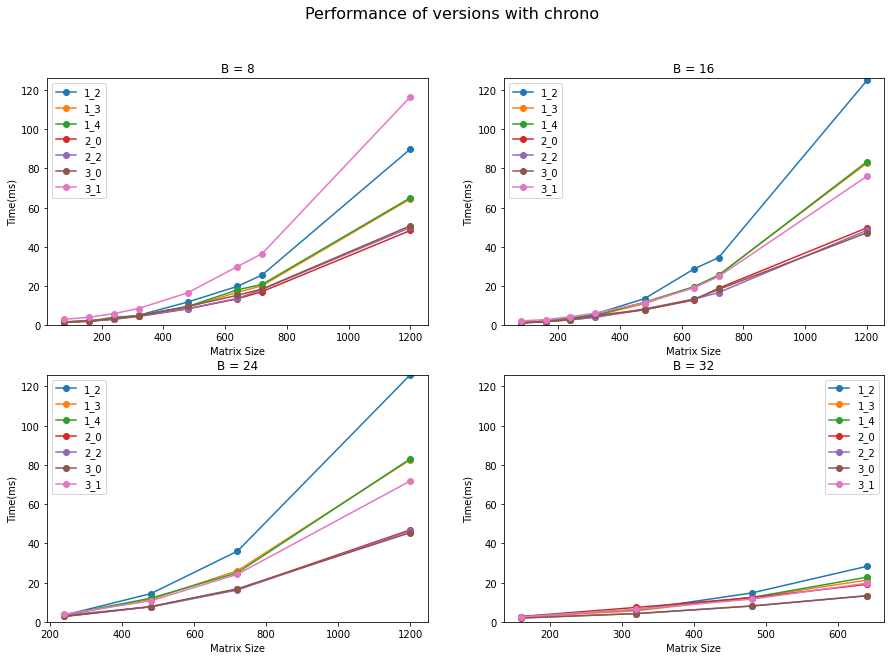

In [15]:
plot_perf_version(df_chrono, 'Time(ms)', 'chrono')

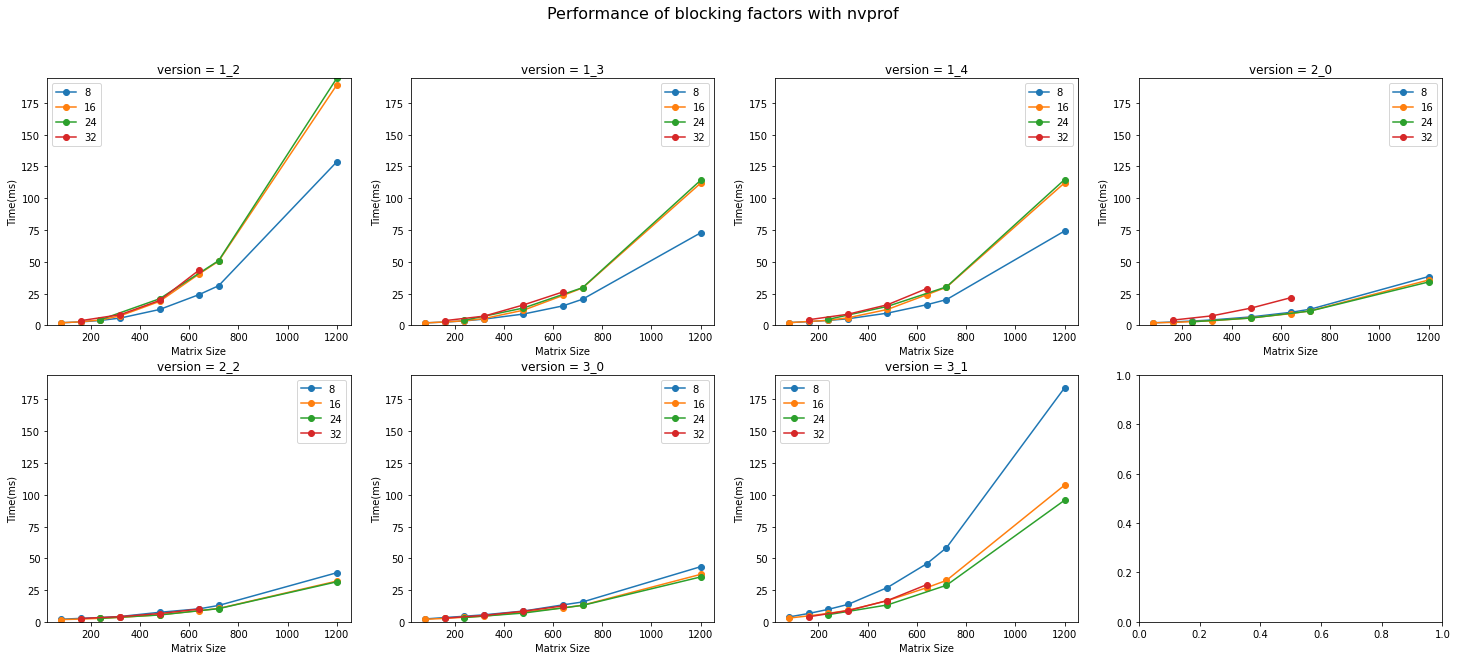

In [16]:
plot_perf_B(df_nvprof, time, 'nvprof')

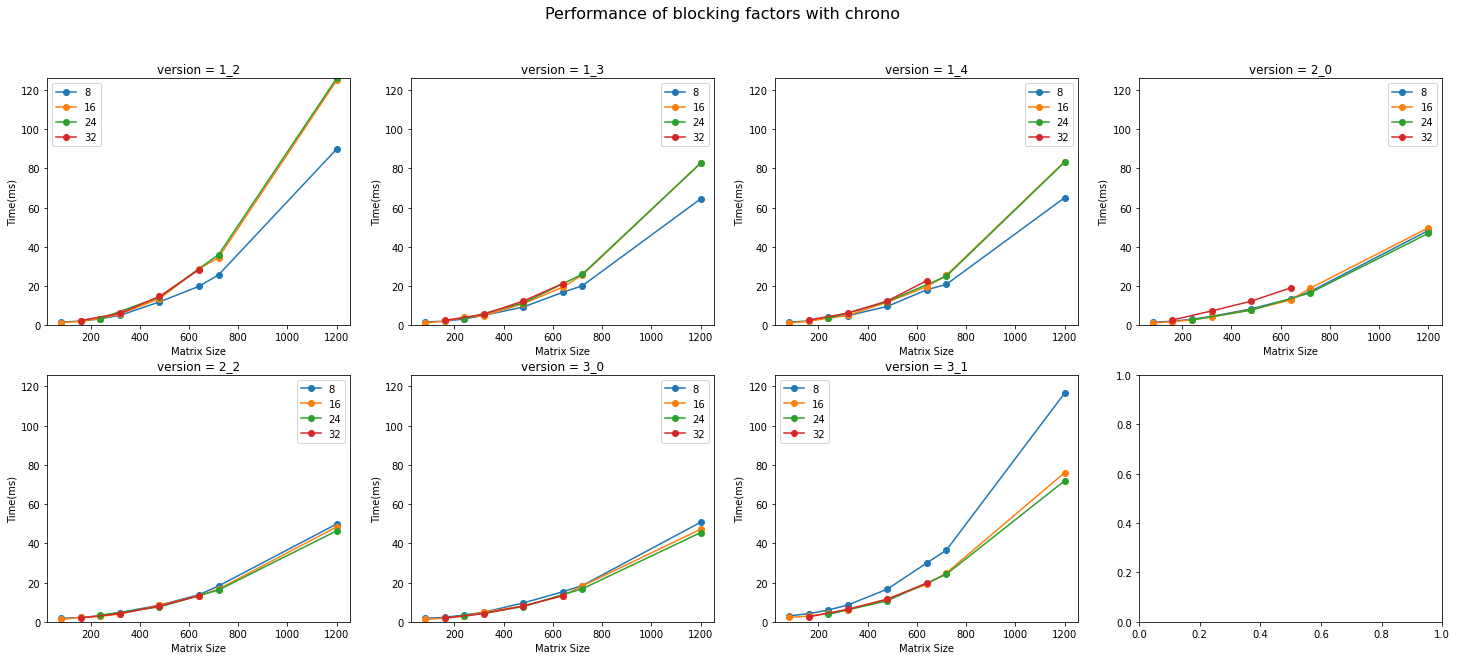

In [17]:
plot_perf_B(df_chrono, 'Time(ms)', 'chrono')

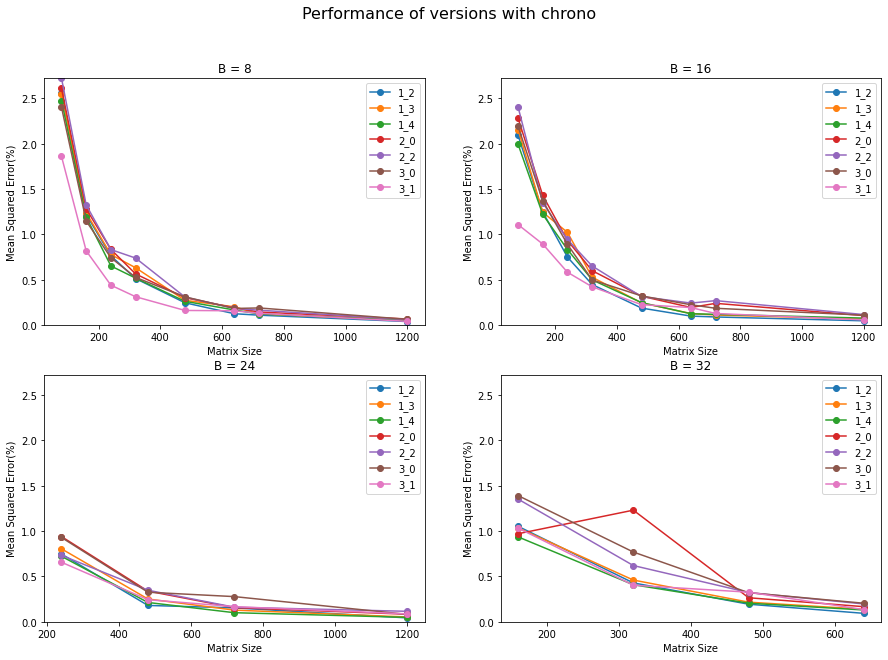

In [18]:
plot_perf_version(df_chrono, 'Mean Squared Error(%)', 'chrono')

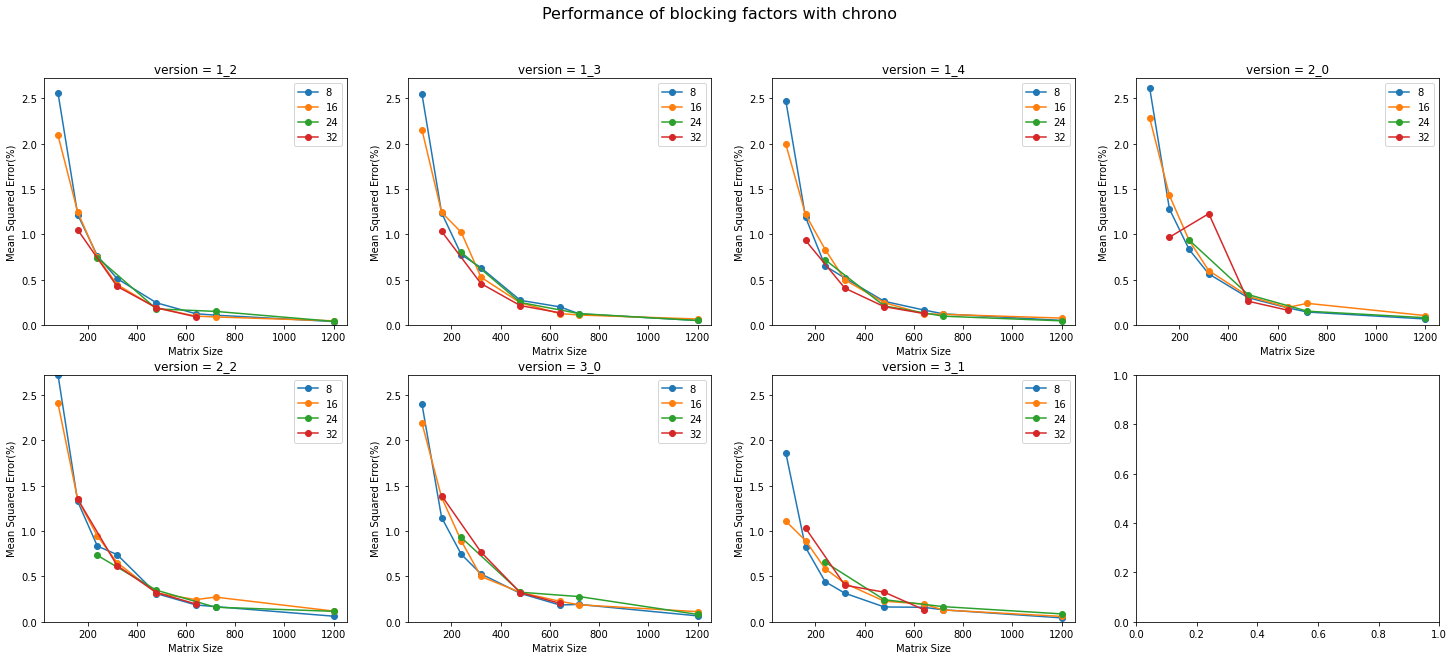

In [19]:
plot_perf_B(df_chrono, 'Mean Squared Error(%)', 'chrono')